In [125]:
import pyswarms as ps
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from lab4.data_preprocessing import truck_df, get_combined_df, distances_df

## This lab tries to solve the VRP using the PSO algorithm

### Distances visualization

In [126]:
distances_df.sample(5)

,Source,Destination,Distance(M)
129,City_31,City_45,1102125
2650,City_23,City_28,141792
898,City_48,City_25,1118501
872,City_48,City_14,1328079
1590,City_21,City_53,2895606


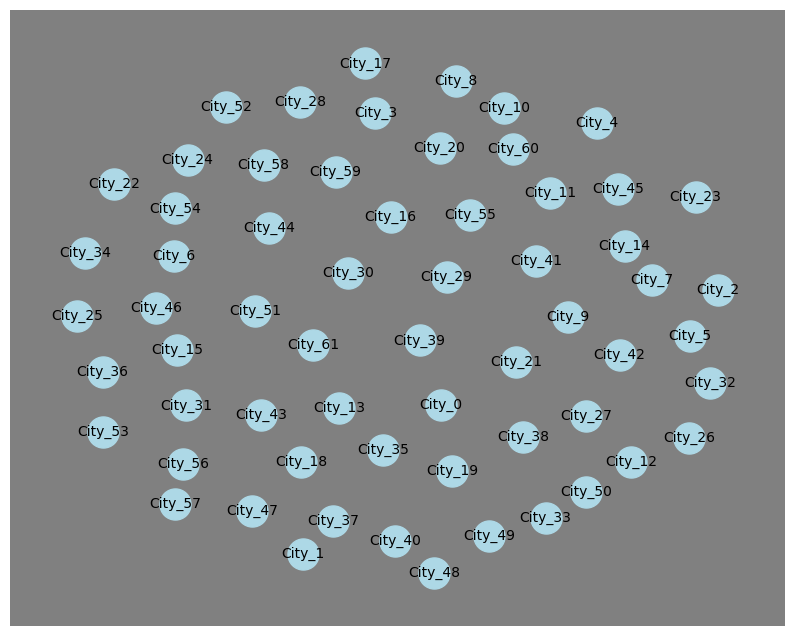

In [127]:
G = nx.from_pandas_edgelist(distances_df, source='Source', target='Destination', edge_attr='Distance(M)')

edge_widths = [d['Distance(M)'] * 2 for (u, v, d) in G.edges(data=True)]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.axis('off')
plt.show()

In [128]:
truck_df

,Truck Type (length in m),Inner Size (m^2),Weight Capacity (kg),Cost Per KM,Speed (km/h)
0,16.5,16.1x2.5,10000,3,40
1,12.5,12.1x2.5,5000,2,35
2,9.6,9.1x2.3,2000,1,30


In [129]:
combined_df = get_combined_df()
combined_df.sample(10)

C:\Users\volodymyr\PycharmProjects\computational_intelligence\lab4\data_preprocessing.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.888 3.888 3.888 ... 1.21  1.21  0.99 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\volodymyr\PycharmProjects\computational_intelligence\lab4\data_preprocessing.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3092.  3092.  3092.  ...   48.9   48.9  162. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  


,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Weight,Distance(M)
4020,A250119,Y-001L,7c88d401-3b3d-4733-9ed2-191b33596a89,City_61,City_18,2022-04-05 23:59:59,2022-04-07 23:59:59,non_danger,0.8362,513.0,960188
1914,A190321,C-0288,9e687b33-3925-4cc4-8734-947e4f263a8c,City_61,City_35,2022-04-05 23:59:59,2022-04-09 23:59:59,type_1,2.1735,1306.8,1728820
898,A240111,M-0835,c1c37020-85ce-4d50-8b73-d883dc9c7039,City_61,City_17,2022-04-07 23:59:59,2022-04-09 11:59:59,type_1,0.9600,740.0,993708
4434,A090424,S-0359,c77f429f-1141-44dc-81e7-6b797a2f3900,City_61,City_24,2022-04-06 23:59:59,2022-04-08 11:59:59,type_1,1.0800,1753.0,737763
4431,A090424,S-0359,3deca51c-8e66-424d-b955-2cd9e93854f5,City_61,City_24,2022-04-06 23:59:59,2022-04-08 11:59:59,type_1,1.0800,1753.0,737763
1747,A010530,C-0438,4e73d067-dc45-4bd6-9899-344ff4f9e42d,City_61,City_13,2022-04-07 23:59:59,2022-04-11 23:59:59,type_1,3.0989,2008.0,1783514
2954,A230515,C-0335,b423db8b-4422-420d-94fb-948229256ce6,City_61,City_58,2022-04-05 23:59:59,2022-04-09 23:59:59,type_1,3.7950,535.0,1754492
4510,A250575,X-6770,126186f5-ead8-4347-a938-9014681bc787,City_61,City_58,2022-04-06 23:59:59,2022-04-10 23:59:59,non_danger,1.2100,169.0,1754492
2327,A210341,C-0327,87848a2d-e8fc-4778-96cd-dbd51cbb9bdc,City_61,City_57,2022-04-05 23:59:59,2022-04-08 23:59:59,type_1,2.6600,1400.0,1776879
560,A260603,F-1AGL,0e2b1851-841a-4217-b68b-8481f8790a89,City_61,City_55,2022-04-06 23:59:59,2022-04-12 23:59:59,type_1,1.2544,690.0,2283914


## Sample target function - minimize costs

In [130]:
num_orders = len(combined_df)
num_trucks = len(truck_df)
dimensions = num_orders * num_trucks
print(f"Dimensions for optimization: {dimensions}")

# Set bounds
bounds = (np.zeros(dimensions), np.ones(dimensions))

def objective_function(x):
    total_costs = []  # Collect costs for all particles
    
    for particle in x: 
        total_cost = 0
        assignment_matrix = particle.reshape((num_orders, num_trucks)).round().astype(int)
        
        for i, order in combined_df.iterrows():
            if sum(assignment_matrix[i]) != 1:
                total_cost += 1e6  # Penalize invalid assignments
                continue

            truck_idx = assignment_matrix[i].argmax()
            truck = truck_df.iloc[truck_idx]
            
            if order["Weight"] <= truck["Weight Capacity (kg)"]:
                total_cost += (order["Distance(M)"] / 1000) * truck["Cost Per KM"]
            else:
                total_cost += 1e6  # Penalize infeasible assignments
        
        total_costs.append(total_cost)
    
    return np.array(total_costs)  # Return costs for all particles


In [132]:
optimizer = ps.global_best.GlobalBestPSO(
    n_particles=30,
    dimensions=dimensions,
    options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
    bounds=bounds
)

In [133]:
best_cost, best_solution = optimizer.optimize(objective_function, iters=100)

print(f"Best cost: {best_cost}")
print(f"Best solution: {best_solution}")

2024-12-15 15:23:17,716 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.67e+9
2024-12-15 15:42:22,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2670420398.800006, best pos: [0.04977811 0.26756327 0.18701431 ... 0.32909388 0.70288141 0.57595512]


Best cost: 2670420398.800006
Best solution shape: (13905,)
